# Baixando as bibliotecas

In [17]:
!pip install mlforecast

!pip install dill

# Importando as bibliotecas

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import dill as pickle

import mlforecast
from mlforecast import MLForecast
from utilsforecast.losses import mae, mape, rmse, smape
from utilsforecast.evaluation import evaluate
from utilsforecast.plotting import plot_series


from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

from mlforecast.auto import (
    AutoLightGBM,
    AutoMLForecast,
    AutoModel,
    AutoRidge,
    ridge_space,
    AutoRandomForest,
    AutoXGBoost,
    AutoLinearRegression,
    AutoLasso,
    AutoElasticNet,
    AutoCatboost,
    xgboost_space,
    catboost_space,
    random_forest_space
)

import warnings
warnings.filterwarnings('ignore')

# Funcoes

In [19]:
def mean_absolute_percentage_error(y_true, y_pred):
      y_true, y_pred = np.array(y_true), np.array(y_pred)
      non_zero_idx = y_true != 0
      return np.mean(np.abs((y_true[non_zero_idx] - y_pred[non_zero_idx]) / y_true[non_zero_idx])) * 100

# Carregando os dados

In [20]:
bucket_uri = "gs://m5_dados/M5_full.parquet"

In [21]:
dados = pd.read_parquet(bucket_uri)

In [22]:
dados['date'] = pd.to_datetime(dados['date'])

In [23]:
last_date = dados['date'].max()

first_day_of_last_month = last_date.replace(day=1)

dados = dados[dados['date'] < first_day_of_last_month]

In [24]:
dados.set_index('date', inplace=True)

In [25]:
dados

,id,item_id,dept_id,cat_id,store_id,state_id,value
date,,,,,,,
2011-01-29,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0
2011-01-29,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0
2011-01-29,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0
2011-01-29,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0
2011-01-29,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0
...,...,...,...,...,...,...,...
2016-04-30,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0
2016-04-30,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0
2016-04-30,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,2


# Criando série temporal das lojas

In [26]:
lojas = dados.groupby(['store_id']).resample('MS')['value'].sum()

# Divisão entre treino e teste com previsão de 6 meses

In [27]:
teste_size = 6
teste = lojas.groupby(['store_id']).tail(teste_size)
train = lojas.drop(teste.index)

# Transformando o DataFrame para o padrão Nixtla

In [28]:
df_train = train.reset_index()
df_test = teste.reset_index()

In [29]:
df_train = df_train.rename(columns={'date': 'ds',
                                    'value': 'y',
                                    'store_id': 'unique_id'})

df_test = df_test.rename(columns={'date': 'ds',
                                  'value': 'y',
                                  'store_id': 'unique_id'})

## Procurando o melhor modelo para a previsão

In [30]:
models={
        'lgb': AutoLightGBM(),
         'rf' : AutoRandomForest(),
         'xgb' : AutoXGBoost(),
         'linear' : AutoLinearRegression()
        }

In [31]:
auto_mlf = AutoMLForecast(
    models=models,
    freq="MS",
    season_length=12,
)

In [32]:
auto_mlf.fit(
    df_train,
    n_windows=6,
    h=6,
    num_samples=6,
)

[I 2024-07-05 16:15:26,372] A new study created in memory with name: no-name-e4cd548c-a256-4186-8350-27ce1f612d2f
[I 2024-07-05 16:15:26,767] Trial 0 finished with value: 0.11370030211261406 and parameters: {'n_estimators': 169, 'lambda_l1': 0.027334069690310565, 'lambda_l2': 0.0026599310838681858, 'num_leaves': 112, 'feature_fraction': 0.7118273996694524, 'bagging_fraction': 0.8229470565333281, 'objective': 'l2', 'target_transforms_idx': 0, 'lags_idx': 0, 'lag_transforms_idx': 3, 'use_date_features': 1}. Best is trial 0 with value: 0.11370030211261406.
[I 2024-07-05 16:15:27,071] Trial 1 finished with value: 0.040642163722436474 and parameters: {'n_estimators': 454, 'lambda_l1': 0.00014233583723829364, 'lambda_l2': 0.10586748269028218, 'num_leaves': 4, 'feature_fraction': 0.819960510663762, 'bagging_fraction': 0.5716766437045232, 'objective': 'l1', 'target_transforms_idx': 2, 'lags_idx': 1, 'lag_transforms_idx': 1, 'use_date_features': 0}. Best is trial 1 with value: 0.040642163722436

AutoMLForecast(models={'lgb': AutoModel(model=LGBMRegressor), 'rf': AutoModel(model=RandomForestRegressor), 'xgb': AutoModel(model=XGBRegressor), 'linear': AutoModel(model=LinearRegression)})

In [33]:
preds = auto_mlf.predict(6)

In [34]:
for i in list(models.keys()):
  preds[i] = preds[i].astype(int)

## Analisando o resultado dos modelos por gráficos

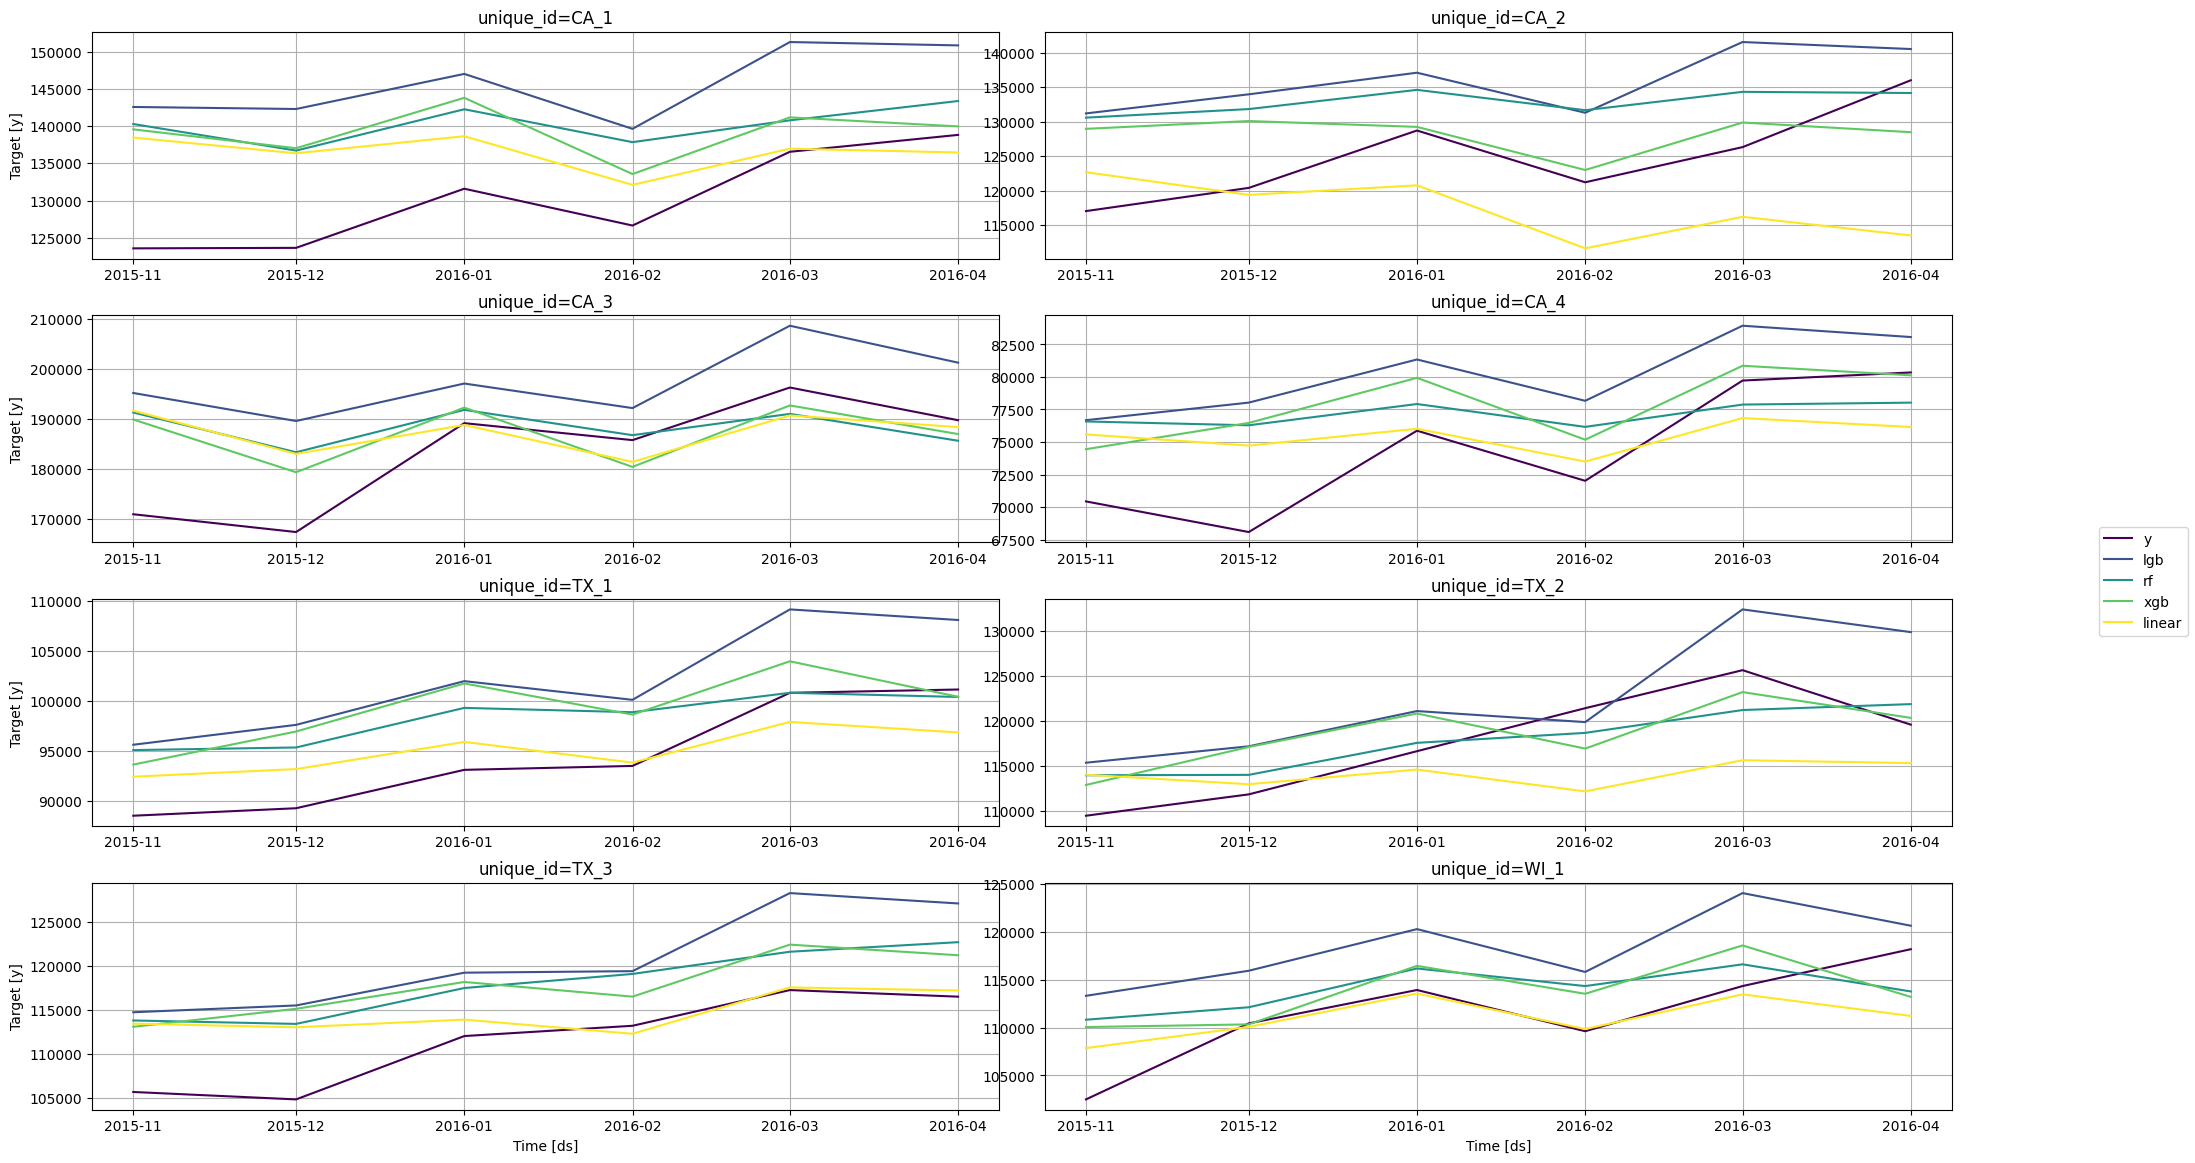

In [35]:
plot_series(df_test, preds, plot_random=False)

## Validando as métricas

In [36]:
previsao_full = df_test.merge(preds, how='right', on=['unique_id', 'ds'])

In [37]:
for i in list(models.keys()):
  print(f'------------------{i}-----------------')
  MAE = mean_absolute_error(df_test['y'], previsao_full[i])
  print(f'Mean Absolute Error: {MAE}')

  MAPE = mean_absolute_percentage_error(df_test['y'], previsao_full[i])
  print(f'Mean absolute percentage error: {MAPE}')

  RMSE = sqrt(mean_squared_error(previsao_full[i], df_test['y']))
  print(f'Root mean squared error: {RMSE}')

  R2 = r2_score(df_test['y'], previsao_full[i])
  print(f'R2: {R2}')
  print('\n')

------------------lgb-----------------
Mean Absolute Error: 9603.65
Mean absolute percentage error: 7.964035322678953
Root mean squared error: 10884.1966194111
R2: 0.8564089434156668


------------------rf-----------------
Mean Absolute Error: 6820.966666666666
Mean absolute percentage error: 5.612961903436865
Root mean squared error: 8823.64174816725
R2: 0.905630779500791


------------------xgb-----------------
Mean Absolute Error: 6344.466666666666
Mean absolute percentage error: 5.23180862882125
Root mean squared error: 8190.336065551075
R2: 0.918691101399041


------------------linear-----------------
Mean Absolute Error: 6510.066666666667
Mean absolute percentage error: 5.2109356986857325
Root mean squared error: 9073.052035193743
R2: 0.9002204738178778




## Analisando o desempenho do melhor modelo

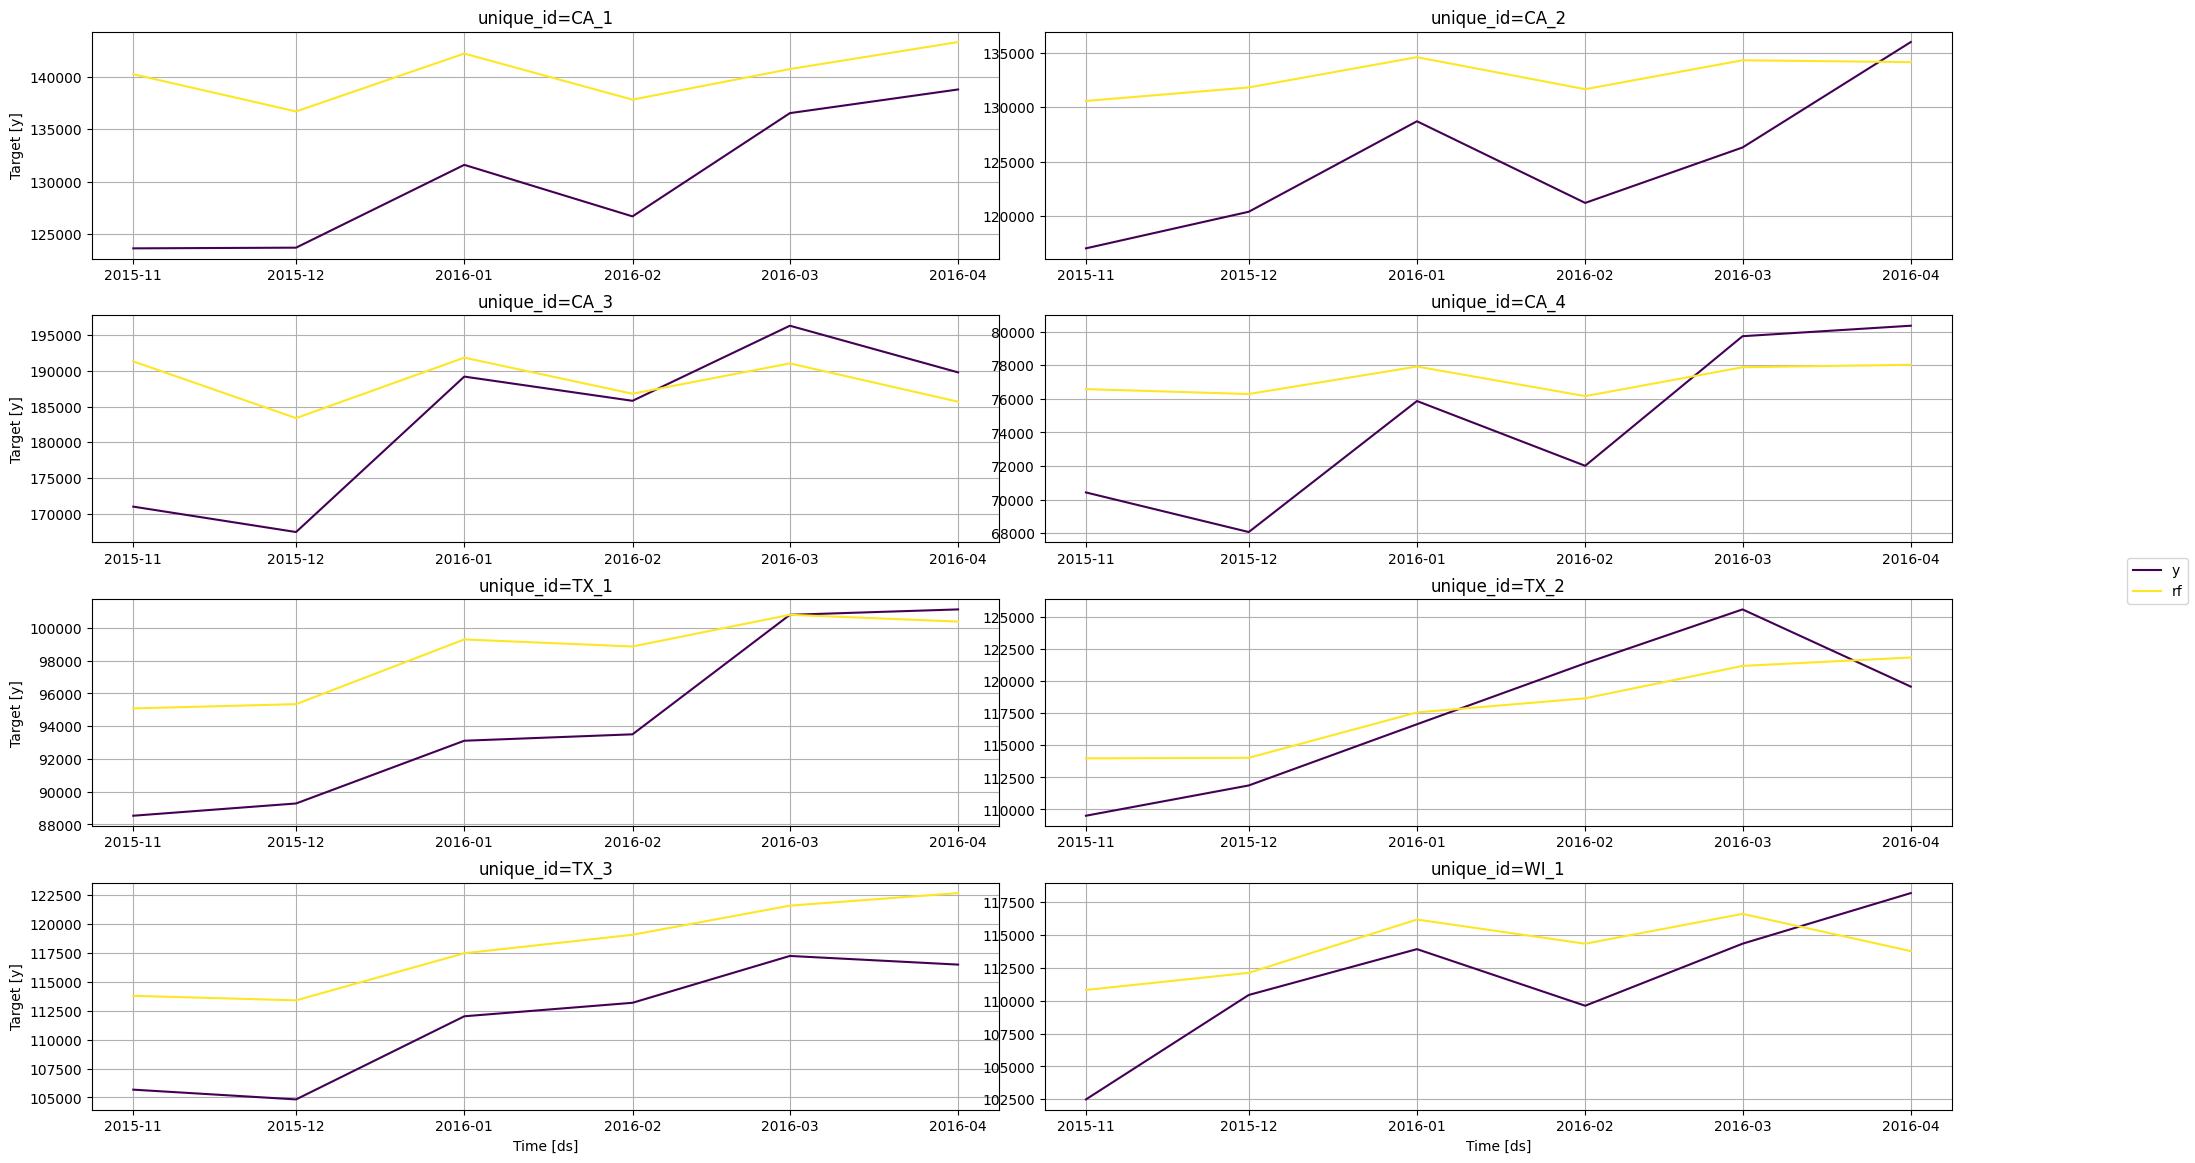

In [38]:
plot_series(df_test, preds[['unique_id', 'ds', 'rf']], plot_random=False)

In [39]:
tabela_validacao = previsao_full[['unique_id', 'ds', 'y', 'rf']]

## Previsão dos próximos 6 meses

In [40]:
models={
         'rf' : AutoRandomForest()
        }

In [41]:
dados_full = pd.concat([df_train, df_test])

In [42]:
auto_mlf_full = AutoMLForecast(
    models=models,
    freq="MS",
    season_length=12,
)

In [43]:
auto_mlf_full.fit(
    df_train,
    n_windows=6,
    h=6,
    num_samples=6,
)

[I 2024-07-05 16:15:46,958] A new study created in memory with name: no-name-34a20c29-d5b4-4f9e-96a0-d9507b555302
[I 2024-07-05 16:15:48,722] Trial 0 finished with value: 0.043279454031747384 and parameters: {'n_estimators': 571, 'max_depth': 8, 'min_child_samples': 61, 'max_features': 0.7724415914984484, 'criterion': 'absolute_error', 'target_transforms_idx': 2, 'lags_idx': 2, 'lag_transforms_idx': 3, 'use_date_features': 1}. Best is trial 0 with value: 0.043279454031747384.
[I 2024-07-05 16:15:51,130] Trial 1 finished with value: 0.04114026155504632 and parameters: {'n_estimators': 877, 'max_depth': 10, 'min_child_samples': 80, 'max_features': 0.7307396811264659, 'criterion': 'squared_error', 'target_transforms_idx': 2, 'lags_idx': 1, 'lag_transforms_idx': 2, 'use_date_features': 1}. Best is trial 1 with value: 0.04114026155504632.
[I 2024-07-05 16:15:53,694] Trial 2 finished with value: 0.057881330550127896 and parameters: {'n_estimators': 947, 'max_depth': 7, 'min_child_samples': 3

AutoMLForecast(models={'rf': AutoModel(model=RandomForestRegressor)})

In [44]:
preds = auto_mlf_full.predict(6)

In [45]:
for i in list(models.keys()):
  preds[i] = preds[i].astype(int)

# Exportando os arquivos

# Exportando o pickle

In [46]:
with open('ModelosPKL/loja.pkl', 'wb') as f:
    pickle.dump(auto_mlf_full, f)

# Previsão futuro

In [47]:
preds.to_csv('previsao_lojas.csv', index=False)

# Validação

In [48]:
tabela_validacao.to_csv('validacao_lojas.csv', index=False)